In [1]:

import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
import config
import pandas as pd 

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [2]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Find data files

In [3]:
# job_id_AEM = 3573022
# job_id_conc = 3573022
# case='SV'




# job_id_AEM = 3573239
# job_id_conc = 3573239 

# job_id_conc = 3753616 #Jul 7, 2020
# job_id_conc = 3845000 #Jul 9, 2020
# case='NM'

#### Completed 500 ######
# job_id_conc = 3845000
# job_id_AEM = 3898968
# case='NM'

# job_id_conc = 3876548
# job_id_AEM = 3899062
# case = 'SV'
#########################

#DSA_yn working in this iteration:
job_id_conc = 3921712
job_id_AEM = 3921712
case='NM'
 




## Find AEM data files
ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id_AEM)).as_posix())
its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])

## Find conc files
output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')
npypaths = glob.glob(output_case.joinpath('conc*{job_id}end.npy'.format(job_id=job_id_conc)).as_posix())
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in npypaths])
tds_in_AEM = np.array([True if it in its_AEM else False for it in its_tds])
AEM_in_tds = np.array([True if it in its_tds else False for it in its_AEM])



# ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id_conc)).as_posix())
# its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
# totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
# failed = totims<14782
# its_failed = its_tds[failed]
# its_success = its_tds[~failed]

strange = np.where(AEM_in_tds is False)
if np.any(strange):
    print('something weird here... failed seawat run ended up with AEM data?')
#     print('removing these indices...')
#     success_AEM[np.array(strange)] = False

print('Case: {}\nNumber of SEAWAT runs: {}'.format(case,len(npypaths)))



Case: NM
Number of SEAWAT runs: 485


##### Load the data

In [4]:
print('loading...')
'''
d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
'''
# d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
# d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


# d_AEM = np.zeros((500,2940),dtype=np.float) 
flag=0
for f,it_AEM in zip(aempaths,its_AEM):
    if flag==0:
        matshape_AEM = np.load(f).shape
        matsize_AEM= np.prod(matshape_AEM)
        d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
        flag=1
    d_AEM[it_AEM] = np.load(f,allow_pickle=True)


flag=0
for f,it_tds,it_inAEM in zip(npypaths,its_tds,tds_in_AEM):   
    if it_inAEM:
        if flag==0:
            matshape_conc =  np.load(f).shape
            matsize_conc = np.prod(matshape_conc)
            d_conc = np.zeros((max(its_tds+1),matsize_conc))
            flag=1
        d_conc[it_tds] = np.load(f).flatten()


        
#Load a specific concentration for prediction variable
# flag=0
# kper=30   #survey kper: 53
# for i,(f,it_tds,it_inAEM) in enumerate(zip(ucnpaths,its_tds,success_AEM)):  
#     if i%50==0:
#         print(i)
#     if it_inAEM:
#         if flag==0:
#             matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
#             matsize_conc = np.prod(matshape_conc)
#             d_conc = np.zeros((max(its_tds+1),matsize_conc))
#             flag=1
# #         d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()
#         ucnobj = flopy.utils.binaryfile.UcnFile(f)
#         d_conc[it_tds] = ucnobj.get_data(kstpkper=(0,kper)).flatten()

        
        
        
        
        

#Verify that mats have missing rows in same indices
if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
    print('matrices line up!')
else:
    print('Warning: matrices do not line up!')        
        
        
keep_inds = np.where(d_conc.any(axis=1))[0]
d_AEM = -d_AEM[keep_inds,:]
d_conc = d_conc[keep_inds,:]
d_conc[d_conc<0]=0.



its_AEM = np.sort(its_AEM)
its_tds = np.sort(its_tds[tds_in_AEM])



loading...
matrices line up!


In [5]:
#Load AEM data
# d_obs_AEM = np.load(datadir.joinpath('AEM','dobs_{}.npy'.format(case)))
d_obs_AEM = np.load(outputdir.joinpath('AEM','obs','dobs_{}_iskip1.npy'.format(case)))

area_304 = 337.04
invalid_msk= d_obs_AEM==9999./area_304
invalid_msk = np.logical_or(invalid_msk,np.isnan(d_AEM[0,:]))
invalid_inds = np.where(invalid_msk)[0]

#Load AEM times
times_HM_304 = np.load(datadir.joinpath('AEM','times_HM_304.npy'))
times_LM_304 = np.load(datadir.joinpath('AEM','times_LM_304.npy'))



# #Take the log
d_obs_AEM=np.log10(d_obs_AEM)
d_AEM=np.log10(d_AEM)

#Remove invalid data
d_conc[d_conc>100]=0.
# d_AEM[:,invalid_inds]=0.
# d_obs_AEM[invalid_inds]=0.

d_AEM = d_AEM[:,~invalid_msk]
d_obs_AEM = d_obs_AEM[~invalid_msk]
d_obs_stash = d_obs_AEM.copy()

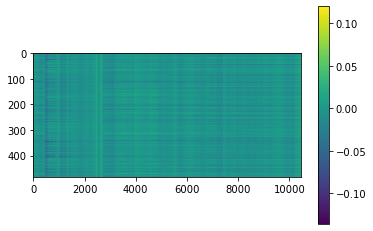

In [6]:
plt.imshow((d_obs_AEM - d_AEM)/d_obs_AEM)
plt.gca().set_aspect(10)
plt.colorbar()

##### Load in SEAWAT model geometry

In [7]:
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5
nmgwmdir_cal_empty = nmgwmdir_cal.parent.joinpath('nmgwmdir_empty')

m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal_empty.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


In [8]:
##Loading
it=10
model_ws = workdir.joinpath('{}_{}'.format(case,it))

modelname = case
m= flopy.seawat.Seawat.load(modelname + '.nam',exe_name=config.swexe, model_ws=model_ws.as_posix())
rows = np.load(model_ws.joinpath('rows.npy'))
starttime = np.load(model_ws.joinpath('starttime.npy'))
layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]
# m = flopy.seawat.Seawat(modelname, exe_name=config.swexe, model_ws=model_ws.as_posix(),verbose=verbose)
# thinmsk_in_aqt = np.load(model_ws.joinpath('thinmsk_in_aqt.npy'))
# wellmsk_in_aqt = np.load(model_ws.joinpath('wellmsk_in_aqt.npy'))
topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
topo_grid_fine = np.loadtxt(GISdir.joinpath('Topography_fine','TopographyMesh_vertices.csv'),skiprows=1,delimiter=',')

if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)


m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())
flopy.modflow.ModflowDis(m_empty, m.nlay, m.nrow, m.ncol, nper=m.nper, delr=m.dis.delr,
                               delc=m.dis.delc,
                               laycbd=0, top=m.dis.top,
                               botm=m.dis.botm, perlen=m.dis.perlen, nstp=m.dis.nstp,
                               steady=m.dis.steady,itmuni=m.dis.itmuni,lenuni=m.dis.lenuni,
                               tsmult=m.dis.tsmult)

xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]





m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


##### Load in TDS data

In [10]:
import psutil
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)


3.9
96.08516925818343


##### Load TDS data to correspond to the correct simulated time (takes forever!!)

In [11]:
from set_rc import set_rc
set_rc()

In [125]:
from shapely.geometry import Point, Polygon

df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]


ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]

#Remove soundings with few time gates
thresh = 15
# (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()
# plt.title('Distribution time gates')
# plt.xlabel('No. invalid time gates')
# plt.ylabel('No. soundings')
# ylims=plt.ylim()
# plt.vlines(thresh,0,ylims[1],label='threshold')
# plt.ylim(ylims)
# plt.legend()

rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
df = df.drop(index=np.r_[remove_inds,remove_inds+1])

#Remove soundings with large jumps
ch1X = df.UTMX.values[::2]
ch2X =  df.UTMX.values[1::2]
ch1Y = df.UTMY.values[::2]
ch2Y =  df.UTMY.values[1::2]
diff = np.sqrt( (ch1X - ch2X)**2 + (ch1Y - ch2Y)**2)
large_jump = diff > np.std(diff)
large_jump_ind = df.UTMX[::2][large_jump].index.values
df = df.drop(index=np.r_[large_jump_ind,large_jump_ind+1])




def utmrotate(x,y,x0=595855,y0=4059438,rotation=13.5,local=False):
    rotation = rotation*np.pi/180
    if local:
        orig_x,orig_y = (0,0)
    else:
        orig_x,orig_y = (x0,y0)
        
    x_rot = np.cos(rotation)*(x-x0) - np.sin(rotation)*(y-y0) + orig_x
    y_rot = np.sin(rotation)*(x-x0) + np.cos(rotation)*(y-y0) + orig_y
    return x_rot,y_rot  

#xll,yll for local grid
xmll,ymll = m_empty.modelgrid.xvertices[-1,0],m_empty.modelgrid.yvertices[-1,0]
xmll_rot,ymll_rot = utmrotate(xmll,ymll,x0=xll,y0=yll)

def global_to_local(x_glob,y_glob,rotx0=xll,roty0=yll,x0_local=xmll_rot,y0_local=ymll_rot):
    x_temp,y_temp = utmrotate(x_glob,y_glob,local=False,x0=rotx0,y0=roty0)
    x_temp -= x0_local
    y_temp -= y0_local
    return np.stack((x_temp,y_temp),axis=1)



#Remove values outside of the AEM_box


iskip = 1
coords = [(m_empty.modelgrid.xvertices[0,0], m_empty.modelgrid.yvertices[0,0]),
          (m_empty.modelgrid.xvertices[-1,0], m_empty.modelgrid.yvertices[-1,0]),
          (m_empty.modelgrid.xvertices[-1,-1], m_empty.modelgrid.yvertices[-1,-1]),
          (m_empty.modelgrid.xvertices[0,-1], m_empty.modelgrid.yvertices[0,-1])
         ]
model_poly = Polygon(coords)
msk_AEM = np.zeros(len(df),dtype=np.bool)
for i,(x,y) in enumerate(zip(df.UTMX.values,df.UTMY.values)):
    msk_AEM[i]=Point(x,y).within(model_poly)
msk = np.logical_and(df.CHANNEL_NO==1, msk_AEM)
data_hm_all = df.loc[msk[msk].index+1,ch2_cols][::iskip]
data_lm_all = df.loc[msk[msk].index,ch1_cols][::iskip]



##### SV plot

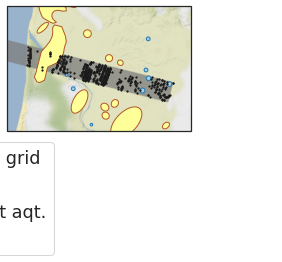

In [126]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(3.3,5))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

g = m_empty.modelgrid.plot(ax=ax,transform=transform,label='SWI model grid',alpha=.3)

ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)
ax.set_extent([605000., 620000.,4060000., 4070000.], crs=transform)

# s = plt.scatter(df_TDS.X_NAD83_UTM10N ,df_TDS.Y_NAD83_UTM10N,
#                 c=(d_tds_obs-d_tds).mean(axis=0)*1000,
# #                 c=df_TDS.perf_start1_elev,
#             zorder=10,cmap='jet',transform=transform,label='Residual')
# plt.legend()
# plt.title('Map of TDS residuals: NM case')

f_exp_thin = GISdir.joinpath("holes","holes_180400_thin").as_posix()
f_exp_well = GISdir.joinpath("holes","holes_180400_well").as_posix()
f_exp = GISdir.joinpath("sva_edge_2","SVA_edge").as_posix()

cmap = sns.color_palette("Paired")
s1 = flopy.plot.plot_shapefile(f_exp_thin,ax=ax,transform=transform,                        
                          facecolor=cmap[-2],edgecolor=cmap[-1],label='thin/absent aqt.',zorder=2)
s2 = flopy.plot.plot_shapefile(f_exp_well,ax=ax,transform=transform,                        
                          facecolor=cmap[0],edgecolor=cmap[1],label='well',zorder=2)

pts1 = plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='k',s=1.5,label='AEM data',transform=transform,zorder=4)
# pts2 = plt.scatter(df.loc[~msk,'UTMX'],df.loc[~msk,'UTMY'],c='grey',alpha=.5,s=1.5,label='AEM data (all)',transform=transform,zorder=3)



import matplotlib.patches as mpatches
s1_patch = mpatches.Patch(facecolor=cmap[-2],edgecolor=cmap[-1], label=s1.get_label())
s2_patch = mpatches.Patch(facecolor=cmap[0],edgecolor=cmap[1], label=s2.get_label())

plt.legend(handles=(g,pts1,s1_patch,s2_patch),bbox_to_anchor=(0.3, -.02))
# cax,kw = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,shrink=0.6)
# out=fig.colorbar(s,cax=cax,**kw)
# label=out.set_label('TDS residual (obs - sim) (mg/L)',size=12,rotation= -90,verticalalignment='bottom')

# plt.savefig(figdir.joinpath('SV_modelgrid_holes.eps'),dpi=300,bbox_inches='tight')

##### NM plot

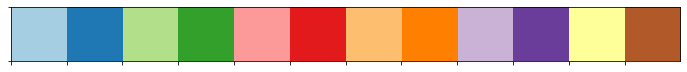

In [23]:
sns.palplot(sns.color_palette("Paired"))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

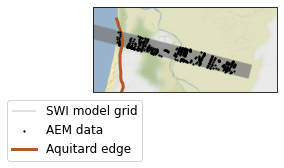

In [17]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
import shapefile as sf

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(3.3,5))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

g = m_empty.modelgrid.plot(ax=ax,transform=transform,label='SWI model grid',alpha=.3)

# ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)
ax.set_extent([604500., 620000.,4059000., 4058000+8000], crs=transform)

# s = plt.scatter(df_TDS.X_NAD83_UTM10N ,df_TDS.Y_NAD83_UTM10N,
#                 c=(d_tds_obs-d_tds).mean(axis=0)*1000,
# #                 c=df_TDS.perf_start1_elev,
#             zorder=10,cmap='jet',transform=transform,label='Residual')
# plt.legend()
# plt.title('Map of TDS residuals: NM case')

f_exp_thin = GISdir.joinpath("holes","holes_180400_thin").as_posix()
f_exp_well = GISdir.joinpath("holes","holes_180400_well").as_posix()
f_exp = GISdir.joinpath("sva_edge_2","SVA_edge").as_posix()

cmap = sns.color_palette("Paired")


sva = sf.Reader(f_exp)

for shape in sva.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
s1 = plt.plot(x,y,color=cmap[-1],label='Aquitard edge',transform=transform,lw=3)


pts1 = plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='k',s=1.5,label='AEM data',transform=transform,zorder=4)
# pts2 = plt.scatter(df.loc[~msk,'UTMX'],df.loc[~msk,'UTMY'],c='grey',alpha=.5,s=1.5,label='AEM data (all)',transform=transform,zorder=3)



import matplotlib.patches as mpatches
# s1_patch = mpatches.Patch(facecolor=cmap[-2],edgecolor=cmap[-1], label=s1.get_label())
# s2_patch = mpatches.Patch(facecolor=cmap[0],edgecolor=cmap[1], label=s2.get_label())

plt.legend(handles=(g,pts1,s1[0]),bbox_to_anchor=(0.3, -.02))
# cax,kw = matplotlib.colorbar.make_axes(ax,location='right',pad=0.05,shrink=0.6)
# out=fig.colorbar(s,cax=cax,**kw)
# label=out.set_label('TDS residual (obs - sim) (mg/L)',size=12,rotation= -90,verticalalignment='bottom')
#
plt.savefig(figdir.joinpath('NM_modelgrid_sva.eps'),dpi=300,bbox_inches='tight')
plt.show()


findfont: Font family ['Corbel'] not found. Falling back to DejaVu Sans.


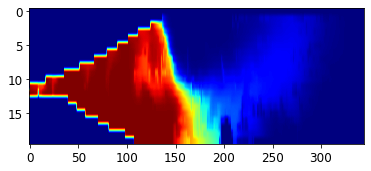

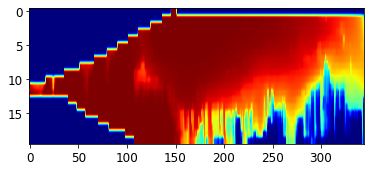

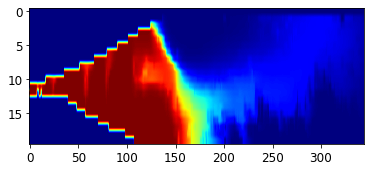

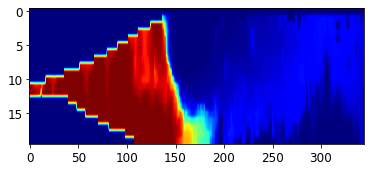

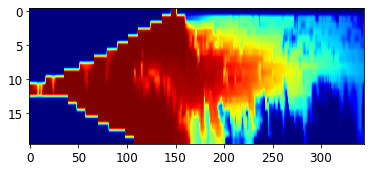

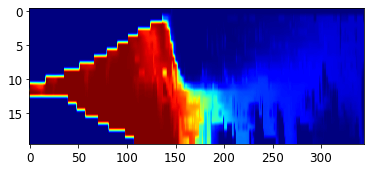

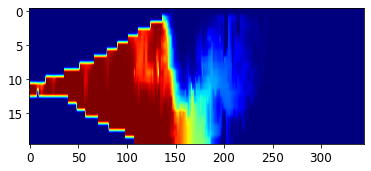

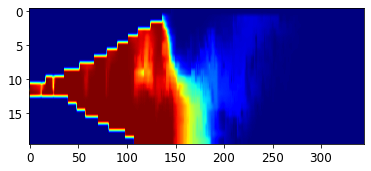

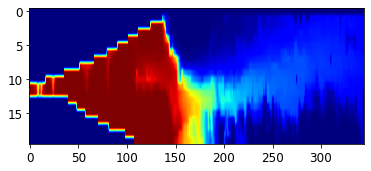

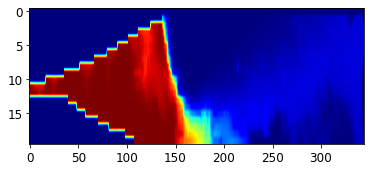

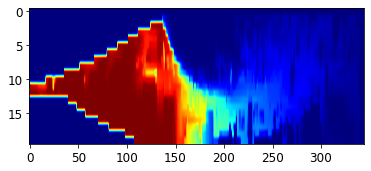

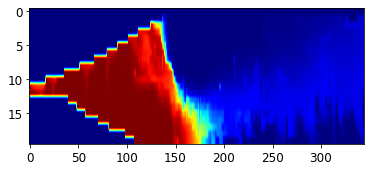

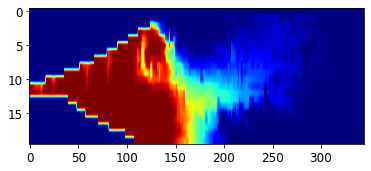

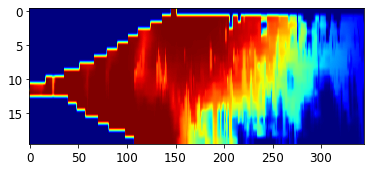

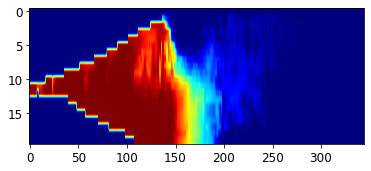

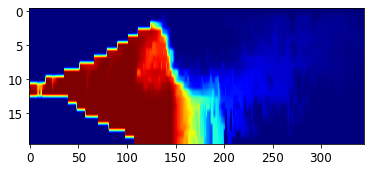

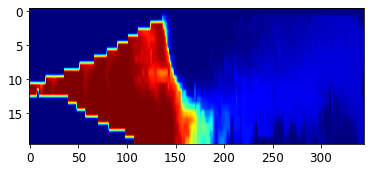

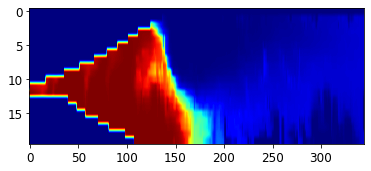

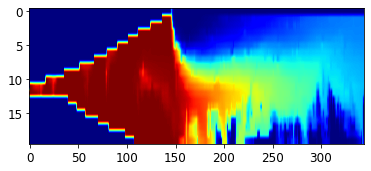

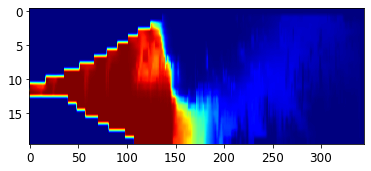

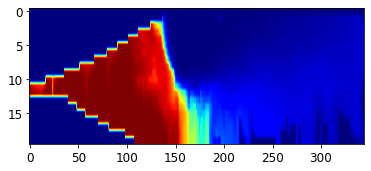

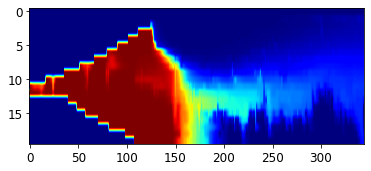

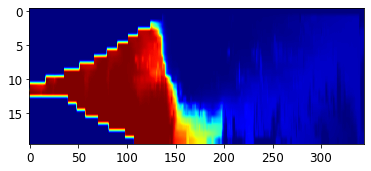

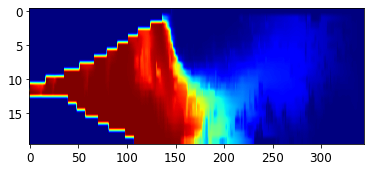

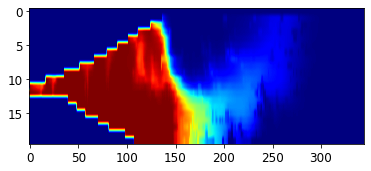

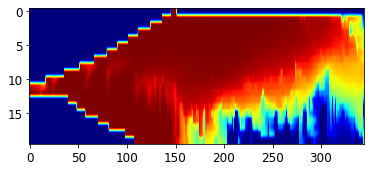

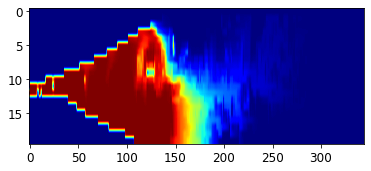

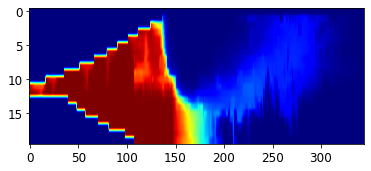

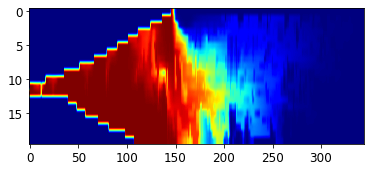

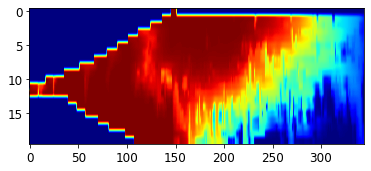

In [12]:
for i in range(20,50):
    plt.figure()
    plt.imshow(d_conc[i].reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
    plt.gca().set_aspect(7)

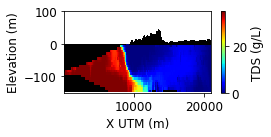

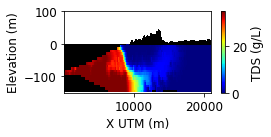

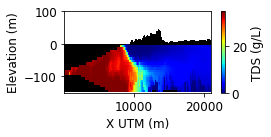

In [13]:
from matplotlib import cm
examps = [0,4,10,13]
examps = [0,1,18]

# examps =[23,]
for examp in examps:
    # conc_var = d_conc.var(axis=0).reshape(matshape_conc)
    conc = d_conc[examp].reshape(matshape_conc)
    conc[conc>100] = np.nan



    slicetype='Row'
    slicenum= 4

    # First step is to set up the plot
    fig = plt.figure(figsize=(3.3, 1.5))
    ax = fig.add_subplot(1, 1, 1)

    # Next we create an instance of the PlotCrossSection class
    xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
    # xsect.plot_ibound()
#     xsect.plot_grid(linewidth=.1)
    # Then we can use the plot_grid() method to draw the grid
    # The return value for this function is a matplotlib LineCollection object,
    # which could be manipulated (or used) later if necessary.
    # linecollection = xsect.plot_grid()
    # patches = xsect.plot_ibound()
    # csa = xsect.plot_array(layer_mapping_ind)
    # cmap = cm.get_cmap('tab10', lay_m.shape[0])
    # csa = xsect.plot_array(kj_lay_red,cmap='tab10')
    # csa = xsect.plot_array(np.log(hk),cmap='viridis')
    # csa = xsect.plot_array(sconc,cmap='jet',vmin=0,vmax=35)

    csa = xsect.plot_array(conc,cmap='jet',vmin=0,vmax=35)
#     csa = xsect.plot_array(conc_var,cmap='jet')

    c = plt.colorbar(csa)
    # wel = xsect.plot_bc("CHD")
    wel = xsect.plot_ibound()
#     wel = xsect.plot_bc("GHB")

#     x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
#     y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
#     c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
#     plt.scatter(x,y,c='r',vmin=0,vmax=35,cmap='jet')




    # t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
    plt.ylabel('Elevation (m)')
    plt.ylim((-150,100))
    plt.xlabel('X UTM (m)')
    c.set_label('TDS (g/L)')
#     plt.savefig(figdir.joinpath('d_conc_example_job{}_it{}_{}.eps'.format(job_idz_conc,examp,case)),dpi=300,bbox_inches='tight')
    plt.show()

##### Dim reduction

In [ ]:
def reshapeAEM(d,values_to_nan=0.):
    d_reshaped = d.reshape((times_HM_304.size+times_LM_304.size, 83), order='F')
    d_reshaped[d_reshaped==values_to_nan] = np.nan
    return d_reshaped[:times_HM_304.size,:],d_reshaped[times_HM_304.size:,:]


# BEL

In [14]:
#FROM AUTOBEL

autobeldir = 'source_code/'
if autobeldir not in sys.path:
    sys.path.insert(0,autobeldir)
    
    
import numpy as np
from sklearn.decomposition import PCA

from source_code.scree_plot import scree_plot
from source_code.evd_fast import *
from source_code.RobustMD_flsification import RobustMD_flsification
from source_code.DGSA_light import DGSA_light
from source_code.gsa_pareto_plt import gsa_pareto_plt
from source_code.rgrplt_all_dh import rgrplt_all_dh 
from source_code.cca_and_ccaplt import cca_d_h
from source_code.cca_and_ccaplt import cca_plt
from source_code.gaussianregression_c_dd_star import *
from source_code.post_est_rtn_val import post_est_rtn_val
from source_code.post_est_rtn_val import post_est_clsplt
from source_code.plt_pos_pri_comp import plt_pos_pri_comp


from source_code.combine_mc_samples import *
from source_code.signed_distance_functions import *
from source_code.giip_cal import *

from source_code.gd_wellog_data import gd_wellog_data
from source_code.falsifications import fals_1Dplt, fals_2Dplt
from source_code.outlier_detection import outlier_2d
from source_code.plt_MC_models_smpls import m_ensampl_plt
from source_code.plt_MC_models_smpls import mc_samples_plot
from source_code.qc_reslts_plt import m_ensampl_plt



In [15]:
def eigen_imgs_local(eigen_vecs, eig_nums,matshape,slicenum=10):
    '''
    This is the function to plot the eigen_images
    arg:
        eigen_vecs: the ndarray of the eigen vectors
        eig_nums: 1d arrary defines which pc numbers to plot
        i_dim, j_dim: the i and j dimension of the grid model        
    '''
    plot_num = len(eig_nums)
    fig_row = int((plot_num+3)/4)
    fig=plt.figure(figsize=(15, fig_row*3))
    
    count = 1
    for i in eig_nums:
        plot=fig.add_subplot(fig_row, 4, count)
        count = count+1
        plt.imshow(eigen_vecs[:,i].reshape(matshape)[:,slicenum,:], cmap='jet')  
        plt.gca().set_aspect(7)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title('model eigen_img (PC' + str(i) +')', fontsize = 14)
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    
    #t = (" ")
    #plt.figure(figsize=(3, 0.1))
    #plt.text(0, 0, t, style='normal', ha='center', fontsize=16, weight = 'bold')
    #plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    #plt.show()
    return

In [16]:
def nst(data,method ='yeo-johnson'):
    from sklearn.preprocessing import PowerTransformer
    #method='box-cox' #another option but requires positive data
    bc = PowerTransformer(method=method)
    data_trans = bc.fit_transform(data)
    return data_trans,bc


  
3. Dimension reduction of model and data
2020-07-13 13:03:56:973417
2020-07-13 13:04:10:143560
QC of the model eigen images
2020-07-13 13:04:12:333276
2020-07-13 13:04:13:494967


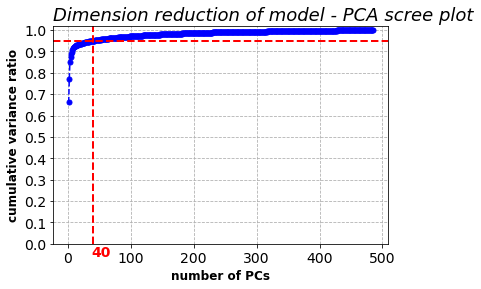

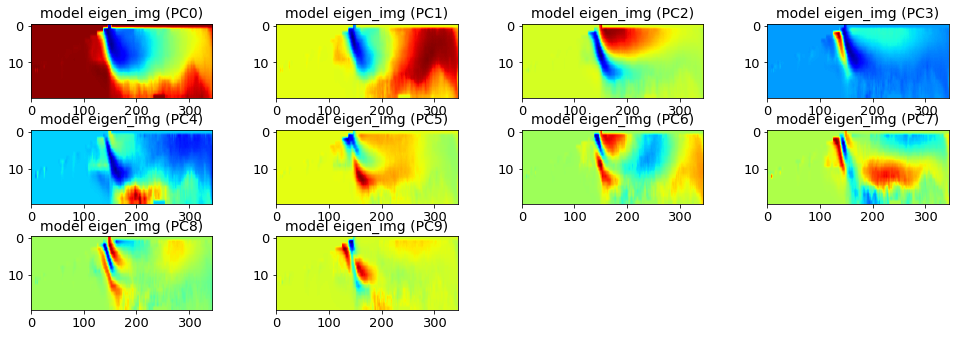

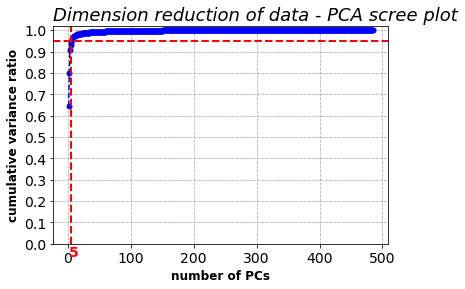

In [20]:
print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''


model_name = '{case}_{job_id_conc}_{job_id_aem}_DSA'.format(case=case,job_id_conc=job_id_conc,job_id_aem=job_id_AEM)

m_pcnums = []
m_pri = d_conc.copy()

m_pcnum =scree_plot(m_pri, 'model', 95, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)




# from sklearn.preprocessing import QuantileTransformer
# rng = np.random.RandomState(0)
# qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
#                          random_state=rng)
# # m_pcscr_pri_nst = qt.fit_transform(m_pcscr_pri[:, :m_pcnum])
# m_pcscr_pri_nst = qt.fit_transform(m_pcscr_pri)





output_model = outputdir.joinpath('BEL',case,'model')
output_data = outputdir.joinpath('BEL',case,'data')

if not output_model.exists():
    output_model.mkdir(parents=True)
if not output_data.exists():
    output_data.mkdir(parents=True)

    
np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)
# np.save(output_model.joinpath('{}_pcscr_pri_nst.npy'.format(model_name)), m_pcscr_pri_nst)




print("QC of the model eigen images")
eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


#TDS
# d_pri = d_tds.copy()
# # d_obs = d_tds_obs.copy()
# d_obs = d_pri[120,:].reshape(1,-1)


#AEM
d_pri = d_AEM.copy()
# d_obs = d_tds_obs.copy()
# d_obs = d_AEM[408,:].reshape(1,-1)
d_obs = d_obs_AEM.copy().reshape(1,-1)

d_pcnum =scree_plot(d_pri, 'data', 95, 'plot')
d_mean_pri = d_pri.mean(axis=0)
d_eigvec_pri = evd_fast(d_pri, len(d_pri))
d_pcscr_pri=(d_pri-d_mean_pri).dot(d_eigvec_pri)
d_pcscr_obs=(d_obs-d_mean_pri).dot(d_eigvec_pri)




np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr_pri)
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_eigvec_pri)


  
4. Prior falsification
Robust Mahalanobis Distance of d_obs =  3.713
97.5th Quantile of Robust Mahalanobis Distance is 8.301
*******************************
>> "NM_3921712_3921712_DSA" Prior CANNOT be falsified!
*******************************


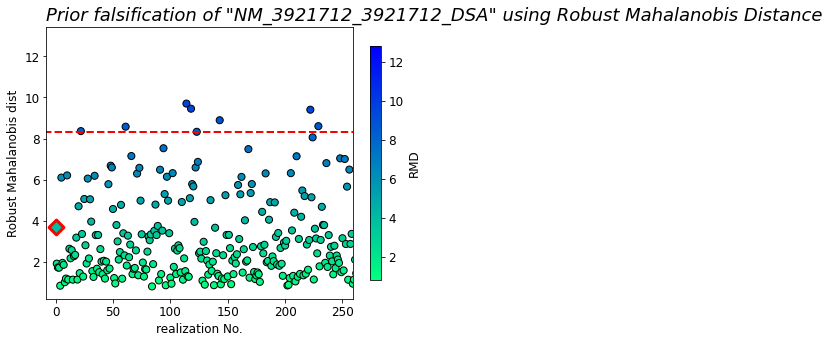

In [21]:
print("  ")
print("4. Prior falsification")
d_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
d_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))[:, :d_pcnum]



# RMD_obs, RMD_Qquantile = RobustMD_flsification(d_pri, d_obs, model_name, True, 99)
RMD_obs, RMD_Qquantile = RobustMD_flsification(d_pcscr_pri, d_pcscr_obs, model_name, True, 97.5)

if RMD_obs >= RMD_Qquantile:
    print("  ")
    print("******************************************************")
    print(' >> "'+model_name+'" Prior is falsified! Please re-design your prior <<')
    print("******************************************************")
else:
    print("*******************************")
    print('>> "'+model_name+'" Prior CANNOT be falsified!')
    print("*******************************")


  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:10<00:00, 296.58it/s]


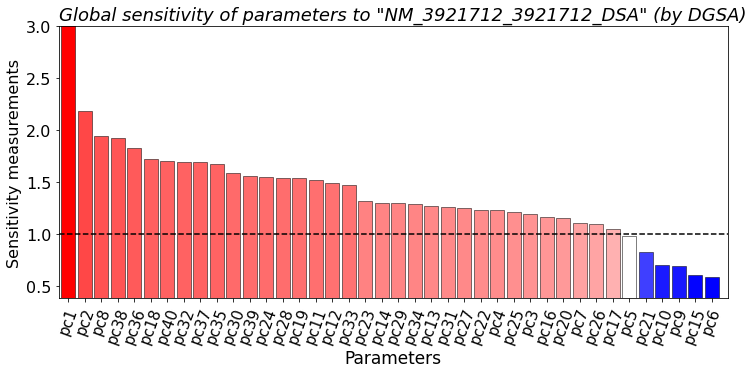

In [22]:
##########################################################################
    ##           STEP 5. GSA               ##
##########################################################################
print("  ")
print("5. Global Sensitivity anlaysis-DGSA")
# m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri_nst.npy'.format(model_name)))[:, :m_pcnum]
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]

d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]

headers = []
for para in range(m_pcnum):
    headers.append('pc' + str(para + 1))
try:
    SA_measure = DGSA_light(m_pcscr_pri, d_pcscr_pri, headers)
except Exception as error:
    print(str(error))
gsa_pareto_plt(SA_measure, model_name)
np.save(output_data.joinpath('SA_measure_' + model_name + '.npy'), SA_measure)


# np.save(output_data.joinpath('DGSA_synth_t{}_{}.npy'.format(kper,model_name)), SA_measure)
# 

##### NST

In [35]:
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))

from sklearn.preprocessing import QuantileTransformer
rng = np.random.RandomState(0)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)
# m_pcscr_pri_nst = qt.fit_transform(m_pcscr_pri[:, :m_pcnum])
m_pcscr_pri_nst = qt.fit_transform(m_pcscr_pri)
np.save(output_model.joinpath('{}_pcscr_pri_nst.npy'.format(model_name)),m_pcscr_pri_nst)

  0%|          | 0/3 [00:00<?, ?it/s]

  
6. Unceratinty reduction
  
6.1 QC model and data statistical relationships


100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


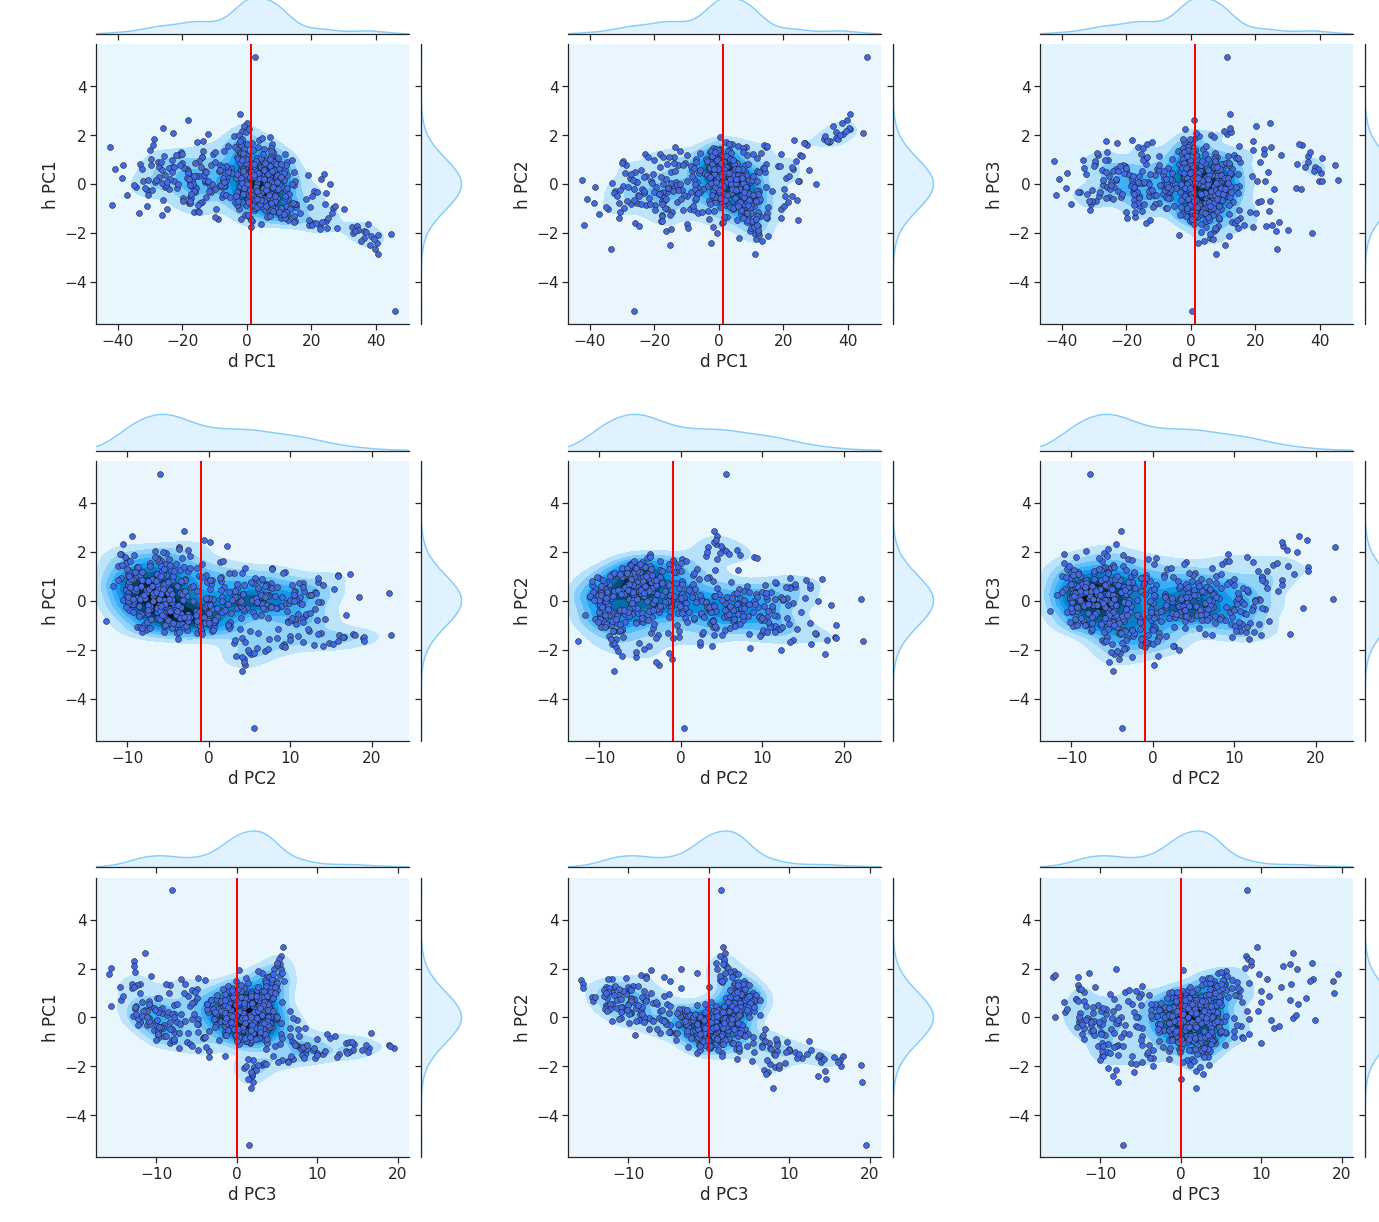

In [36]:
##########################################################################
    ##           STEP 6.  Uncertainty reduction              ##
##########################################################################
print("  ")
print("6. Unceratinty reduction")
print("  ")
##########################################################################
##          STEP 6.1     QC statistical relationships           ##
print("6.1 QC model and data statistical relationships")
SA_measure = np.load(output_data.joinpath('SA_measure_' + model_name + '.npy'))[:, 0]
sensitive_pcnum = np.where(SA_measure > 1)[0][:d_pcnum]

# m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri_nst.npy'.format(model_name)))[:, :m_pcnum]

d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))[:,:d_pcnum]

rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
              [1, 2, 3], [1, 2, 3])

m_star = m_pcscr_pri[:, sensitive_pcnum]
d_star = d_pcscr_pri
dobs_star = d_pcscr_obs


  
6.2 Canonical Corrleation Analysis


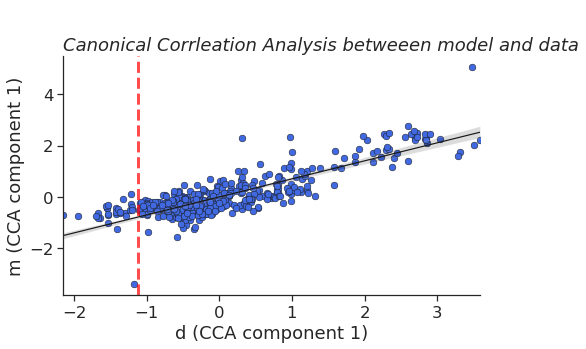

In [37]:
#######################################################################
##          STEP 6.2  CCA             ##
print("  ")
print("6.2 Canonical Corrleation Analysis")

d_c, m_c, ad, am = cca_d_h(d_star, m_star, m_star.shape[1])
dobs_c = np.matmul(dobs_star, ad)
d_c = np.matmul(d_star, ad)
m_c = np.matmul(m_star, am)
cca_plt(d_c, m_c, dobs_c, 1)


  
6.4 Reconstruct posterior model


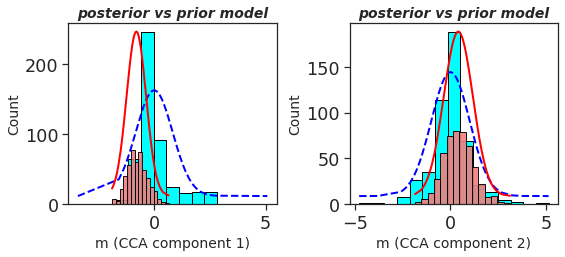

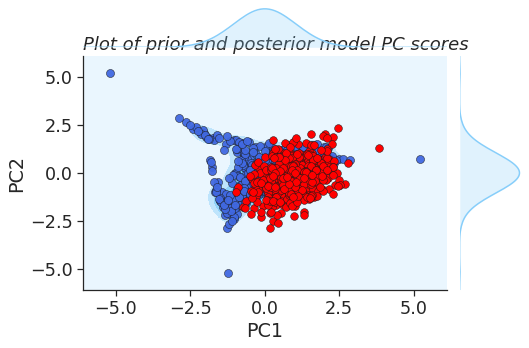

In [39]:
def post_est_rtn_val_local(cca_comp, h_c,d_c, d_obs_c, c_dd_star, fig_ind):

    com = cca_comp
    #### Estimate f(h*) of priors
    h_c_pri=np.sort(h_c[:,com-1])
    h_star_bar=np.mean(h_c[:,com-1])
    c_hst_hst = np.var(h_c_pri)
    f_pri=1/(c_hst_hst * np.sqrt(2 * np.pi))*    np.exp(-(h_star_bar-h_c_pri)*(h_star_bar-h_c_pri)/(c_hst_hst*2))
    #### **** ####

    ####### ESTIMATE Posteriors ###
    g_dh=stats.linregress(h_c[:,com-1],d_c[:,com-1])[0]
    epsil=(g_dh*h_c[:,com-1]-d_c[:,com-1])
    c_epsil=np.var(epsil)
    
    #c_dd_star=d_pca_comp[0][0]*0.1*cca.x_loadings_[0][0]
    #c_dd_star= c_dd_star[com-1, com-1]

    c_dst_dst = c_epsil + c_dd_star[com-1, com-1]

    h_hat_star=1/(g_dh/c_dst_dst+1/c_hst_hst)*(g_dh/c_dst_dst*d_obs_c[:,com-1]+1/c_hst_hst*h_star_bar)
    c_hat_hsthst_star=1/(g_dh/c_dst_dst*g_dh+1/c_hst_hst)

    mean_post=h_hat_star

    std_post=np.sqrt(c_hat_hsthst_star)
    
    ##*** SAMPLE POSTERIORS ***##
    h_c_post=np.random.normal(mean_post,std_post,len(h_c))
    #####*****####
     
    ###### Plots #####
    if fig_ind == 1:
        fig, ax1 = plt.subplots(figsize=(6,4))
        ax2=ax1.twinx()

        bins=np.sort(h_c_post)
        ## Priors
        ax1.hist(h_c[:,com-1], 15, edgecolor='black', facecolor='aqua')
        ax2.plot(h_c_pri, f_pri, '--', linewidth = 2, c='b')
        ## Posteriors
        ax1.hist(h_c_post,bins=15, edgecolor='black', facecolor='lightcoral', alpha = 0.8)

        ax2.plot(bins, 1/(std_post * np.sqrt(2 * np.pi))*np.exp( - (bins - mean_post)**2 / (2 * std_post**2) ), linewidth=2, color='red')

        ax1.set_xlabel('h (CCA componennt_'+ str(com) +' score)',fontsize = 14)
    
    return h_c_post,mean_post,std_post



print("  ")
print("6.4 Reconstruct posterior model")

err_levl = 0.03
dpca_eigenvec = np.load(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)))[:,:d_pcnum].T
# cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, dobs_c)
cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, d_obs_AEM.copy().reshape(1,-1))


post_est_clsplt([1, 2,], m_c, d_c, dobs_c, cdd_star, 2, 2)

all_mc_post = []
all_mean_post = []
all_std_post = []
samps = []
for cca_comp in range(1, len(m_star[0, :]) + 1):
    h_c_post,mean_post,std_post = post_est_rtn_val_local(
        cca_comp, m_c, d_c, dobs_c, cdd_star, 0)
    all_mc_post.append(h_c_post)
    all_mean_post.append(mean_post)
    all_std_post.append(std_post)
    samps.append(np.random.normal(mean_post,std_post,1000))
    
all_mc_post = np.asarray(all_mc_post).T
samps = np.asarray(samps).T

m_pcscr_post_SA = all_mc_post.dot(np.linalg.inv(am))
samps_SA = samps.dot(np.linalg.inv(am))





m_pcscr_post = np.load(output_model.joinpath('{}_pcscr_pri_nst.npy'.format(model_name))) 

# m_pcscr_post = np.load(output_model.joinpath(model_name + '_pcscr_pri.npy'))

m_pcscr_post[:, sensitive_pcnum] = m_pcscr_post_SA



plt_pos_pri_comp(
    sensitive_pcnum[0] + 1, sensitive_pcnum[1] + 1, m_pcscr_pri, m_pcscr_post)

m_eigvec = np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))
m_pri_mean = np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))

m_pcscr_post = qt.inverse_transform(m_pcscr_post)


m_post = m_pcscr_post.dot(m_eigvec.T) + m_pri_mean



In [41]:

def mc_samples_plot_2(model_ndarray, m_name, pri_post, matshape, layernum,aspect=1,**kwargs):
    '''
    Plot the 1st to 12th monte carlo model samples. 
    Args:
        model_ndarray: (str) the ndarray of monte carlo model samples, N_realizations x Grid_dims
        i_dim, j_dim, k_dim: x, y, z dimensions of one model realization. 
        layernum: which layer to show
        m_type: type of the model, 1 - continous; 2 - categorical
        
    Output:
        Pareto Plot for SA
    '''
    fig=plt.figure(figsize=(15,14))
    count = 1
    for realnum in range(12):
        if count  == 12:
            plot=fig.add_subplot(3, 4, count)
            plt.text(0.1, 0.48, '...', fontsize=50)
            plt.text(0.0, 0.6, 'Total ' + str(len(model_ndarray))+' samples', fontsize=16, style='italic')
            plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
            count = count + 1
        else:

            grid_data = model_ndarray[realnum].reshape(matshape)         
            plot=fig.add_subplot(3, 4, count)
            count = count+1

            prop_mean = format(np.mean(grid_data),'.4f')
            plot.set_xlabel('average "' + m_name + '" = ' + str(prop_mean), fontsize = 14)
            c_max = np.max(grid_data[layernum-1])*1.05
            c_min = np.min(grid_data[layernum-1])

            plt.imshow(grid_data[:,layernum,:],**kwargs)  
            plt.gca().set_aspect(aspect)
            plt.xticks(fontsize = 13)
            plt.yticks(fontsize = 13)
            plt.title(pri_post +' ' +m_name+ ' model #'+str(count-1), fontsize=14, style='italic')

#             plt.colorbar(fraction = 0.02)
            plt.colorbar(fraction = 0.02, ticks=np.around([c_min*1.1, c_max], decimals=1))
    plt.subplots_adjust(top=0.55, bottom=0.08, left=0.10, right=0.95, hspace=0.15,
                    wspace=0.35)
    return

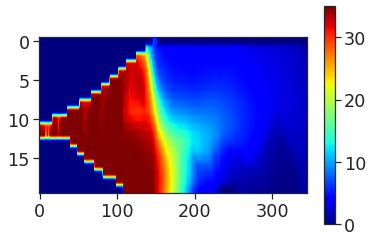

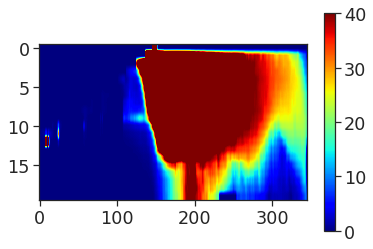

In [43]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc==0]=0

plt.imshow(d_conc_plot.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=40)
plt.gca().set_aspect(10)
plt.colorbar()

In [45]:
np.save(output_model.joinpath('NM_3921712_3921712_DSA_model_post_0713.npy'),m_post)
np.save(output_model.joinpath('NM_3921712_3921712_DSA_model_pri_0713.npy'),d_conc_plot)

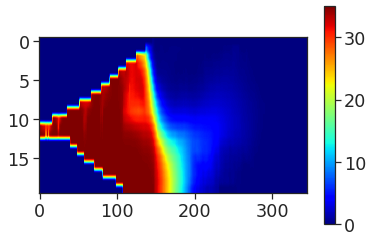

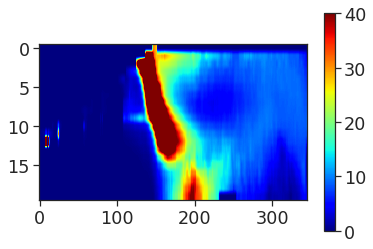

In [42]:
# m_post[m_post==0] = np.nan

plt.imshow(m_post.mean(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=35)
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()
plt.imshow(m_post.var(axis=0).reshape(matshape_conc)[:,10,:],cmap='jet',vmin=0,vmax=40)
plt.gca().set_aspect(10)
plt.colorbar()

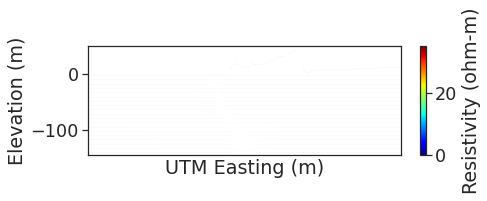

In [44]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
# xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(m_post.mean(axis=0).reshape(matshape_conc),cmap='jet',vmin=0,vmax=35)
# csa = xsect.plot_array(kj_lay2,cmap='tab10')

c = plt.colorbar(csa)
c.set_label('Resistivity (ohm-m)')

# tcks = np.linspace(0,2,21)
# lbls = [int(10**v) if v in tcks[(np.array((0,7,10,17,20)))] else '' for v in tcks]

# c.set_ticks(tcks)
# c.set_ticklabels(lbls)

# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
# wel = xsect.plot_bc("GHB")

# x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
# y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
# c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
# plt.scatter(x,y,c=c,vmin=0,vmax=35,cmap='jet')

xlims = plt.xlim()
plt.xticks(np.arange(598000,xlims[1]+1000,4000))
plt.xlim(xlims)



plt.ylabel('Elevation (m)')
plt.ylim((-145,50))
plt.xlabel('UTM Easting (m)')
# plt.savefig(figdir.joinpath('mpri_var_NM_cmap2.eps'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

# plt.savefig(figdir.joinpath('m_AEM_res.eps'),dpi=300,bbox_inches='tight')
plt.show()


In [117]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc==0]=0


In [119]:
np.save(output_model.joinpath(model_name + '_model_pri'),d_conc_plot)

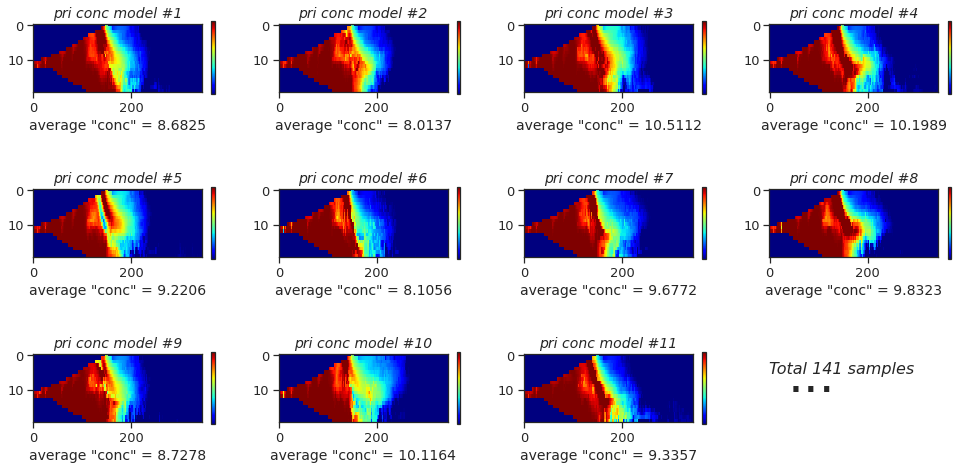

In [62]:
mc_samples_plot_2(m_post,'conc','post',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')




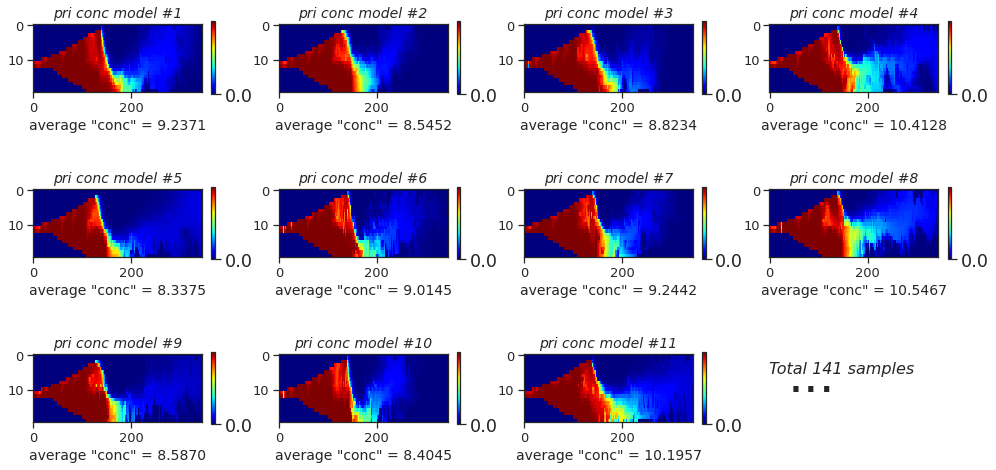

In [63]:
d_conc_plot = d_conc.copy()
d_conc_plot[d_conc==0]=0
mc_samples_plot_2(d_conc_plot,'conc','pri',matshape_conc,10,aspect=7,cmap='jet',
                           vmin=0,vmax=35.,interpolation='nearest')



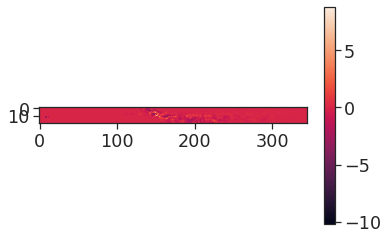

In [155]:
plt.imshow(m_post.var(axis=0).reshape(matshape_conc)[:,10,:] - 
           d_conc_plot.var(axis=0).reshape(matshape_conc)[:,10,:])
plt.colorbar()

In [114]:
output_model

PosixPath('/scratch/users/ianpg/SWIlarge/work/output/BEL/NM/model')

In [109]:
m.nrow

19

In [2]:
matshape_conc

NameError: name 'matshape_conc' is not defined

In [1]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m_empty, line={slicetype: slicenum},geographic_coords=True,ax=ax)
# xsect.plot_ibound()
# xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(np.log10(m.lpf.hk.array))

# csa = xsect.plot_array(m_post.mean(axis=0).reshape(matshape_conc))#,cmap='jet',vmin=0,vmax=35)

# c = plt.colorbar(csa)
# c.set_label('TDS (g/L)')


# csa = xsect.contour_array(hd,levels= np.linspace(-10,2,20),cmap='viridis')
c = plt.colorbar(csa)
c.set_label('TDS (mg/L)')



# wel = xsect.plot_bc("CHD")
# wel = xsect.plot_ibound()
# wel = xsect.plot_bc("GHB")

# x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
# y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
# c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
# plt.scatter(x,y,c=c,vmin=0,vmax=35,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,100))
plt.xlabel('X UTM (m)')
plt.show()
# plt.savefig(figdir.joinpath('xsection_conc.png'),dpi=300,bbox_inches='tight')

NameError: name 'plt' is not defined

In [100]:
np.where(m_post>100)

(array([], dtype=int64), array([], dtype=int64))

In [100]:
plt.subplots(figsize=(9,4.5))
sns.distplot(giip_a, bins=int(len(giip_a)/10), \
            kde_kws={'linewidth': 2,"color":"blue"}, \
            hist_kws={'color':'aqua',"edgecolor":'black','linewidth':0.6,'alpha':0.95})

sns.distplot(giip_b, bins=int(len(giip_b)/12.5), \
            kde_kws={'linewidth': 3,  "color":"red", }, \
            hist_kws={'color':'tomato',"edgecolor":'black','linewidth':0.6, 'alpha':0.7})
plt.ylabel('Density', fontsize = 20, fontname='calibri')
plt.xlabel('GIIP', fontsize = 20, fontname='calibri')
plt.title('Posterior and Prior predicton with "' + model_name+ '" model', fontsize=18, loc='right', style='italic')

(494, 131100)

In [121]:

#######################################################################
##          STEP 6.5 QC posterior results               ##

print("  ")
print("6.5. QC posterior results")
print("  ")
print("6.5.1 Plot posterior models")
m_pri = np.load(pri_m_samples_dir + model_names[i] + '.npy')
d_obs = np.c_[np.loadtxt(fname=dobs_file, skiprows=1)[:, :3], np.loadtxt(
    fname=dobs_file, skiprows=1)[:, i + 3:i + 4]]
# m_sampls_plt(m_post, samples_size, model_names[i], x_dim, y_dim, z_dim)
mc_samples_plot(m_post, model_names[i], model_types[
                i], 'Posterior', x_dim, y_dim, z_dim, 1)
m_ensampl_plt(m_post, m_pri,  model_names[
              i], 1, x_dim, y_dim, 1, d_obs)

print("  ")
print("6.5.2 Calculate posterior prediction")
GIIP_post = GIIP_cal(1, 0, m_post, grid_h_resolution, False)
np.save('output/prediction/GIIP_post', GIIP_post)
GIIP_pri = np.load('output/prediction/GIIP_pri.npy')
giip_compare(GIIP_pri, GIIP_post, model_names[i])



  
6.5. QC posterior results
  
6.5.1 Plot posterior models


NameError: name 'pri_m_samples_dir' is not defined

In [101]:
giip_compare??

In [38]:
d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))
m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))
d_pcscr_obs = np.load(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)))

In [26]:
m_pcscr_pri.shape

(494, 494)

In [23]:
np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_pca.components_)

np.load(output_model.joinpath('{}_mean_pri.npy'.format(model_name)))
np.load(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)))



['test']

In [66]:
from scipy.spatial.distance import pdist,squareform

In [67]:
# distmat = squareform(pdist(np.r_[d_AEM,d_obs.reshape(1,-1)],))
from scipy.spatial.distance import pdist,squareform
distmat = squareform(pdist(np.r_[d_pri,d_obs]))

In [153]:
maxind = np.argmax(distmat[-1,:-1])
its_AEM[maxind]

156

In [169]:
its_AEM[269]

280

In [168]:
np.where(distmat[-1,:-1]==np.sort(distmat[-1,:-1])[1])

(array([269]),)

In [68]:
minind = distmat[-1,:-1]
min_AEM = d_AEM[minind,:]

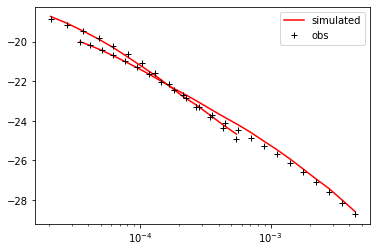

In [110]:
dHM,dLM = reshapeAEM(min_AEM)
dHMobs,dLMobs = reshapeAEM(d_obs_stash)

i_line=22
n_lines=1
plt.semilogx(times_HM_304,dHM[:,i_line:i_line+n_lines],'r',label='simulated')
plt.semilogx(times_LM_304,dLM[:,i_line:i_line+n_lines],'r')

plt.semilogx(times_HM_304,dHMobs[:,i_line:i_line+n_lines],'k+',label='obs')
plt.semilogx(times_LM_304,dLMobs[:,i_line:i_line+n_lines],'k+')
plt.legend()

In [109]:
diff_dbdt = np.abs(np.nanmin((dHM - dHMobs),axis=0))
diff_dbdt[np.isnan(diff_dbdt)]=100.
np.argmin(diff_dbdt)

22

In [112]:
its_AEM[minind]

406

In [115]:
case

'SV'

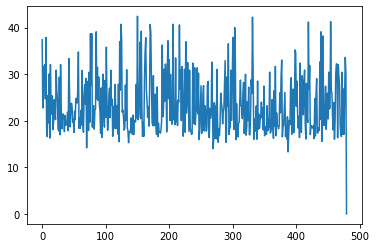

In [114]:
plt.plot(distmat[-1,:])


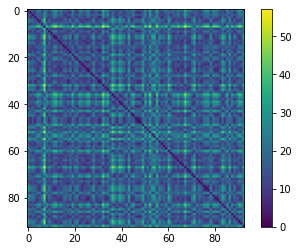

In [73]:
plt.imshow(distmat[minind:,minind:])
plt.colorbar()

(array([2.42000e+02, 7.25000e+02, 6.08800e+03, 1.49954e+05, 3.97700e+03,
        5.00000e+02, 5.50000e+01, 3.30000e+01, 1.40000e+01, 1.60000e+01]),
 array([-5.13202974e-09, -3.64171348e-09, -2.15139722e-09, -6.61080964e-10,
         8.29235295e-10,  2.31955155e-09,  3.80986781e-09,  5.30018407e-09,
         6.79050033e-09,  8.28081659e-09,  9.77113285e-09]),
 <a list of 10 Patch objects>)

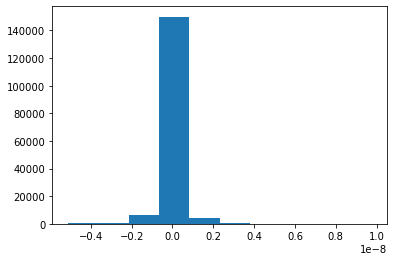

In [116]:
plt.hist((d_pri-d_obs).flatten())

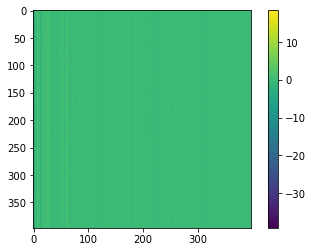

In [87]:
plt.imshow(d_pri-d_obs)
plt.colorbar()

##### Load observed data

##### Mahabonabonlis distance

In [ ]:
m_eigvec_pri.shape

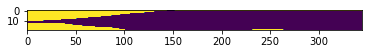

In [41]:
plt.imshow(d_conc[0].reshape(matshape_conc)[:,0,:])

### Plot

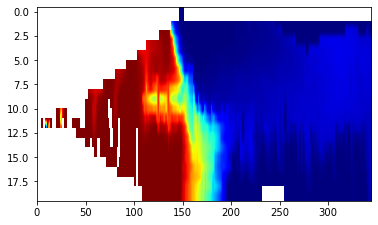

In [94]:
conc[conc>100]=np.nan

plt.imshow(conc[:,10,:],vmin=0,vmax=35.,cmap='jet')
plt.gca().set_aspect(10)

In [76]:
for f in ucn

TypeError: only integer scalar arrays can be converted to a scalar index

In [74]:
dd = {}

for 



233

In [59]:
data

In [19]:
ucnpaths = glob.glob(output_SV.joinpath('*_{}.UCN'.format(job_id)).as_posix())
f= ucnpaths[0]
f.split('_')

['/scratch/users/ianpg/SWIlarge/work/output/SV/conc75',
 '20200704',
 '1110',
 'totim14782',
 '3573022.UCN']

In [25]:
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
